In [13]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
from matplotlib import pyplot as plt
from bs4 import BeautifulSoup as bs
import requests
import lxml
import html5lib
import time
import random
from requests.adapters import HTTPAdapter
from requests.packages.urllib3.util.retry import Retry

## Get the 250 TV Series with the highest average rating. 

In [89]:
# Page with highest rating average 250 TV series
URL = "https://www.imdb.com/chart/toptv/?ref_=nv_tvv_50"
page = requests.get(URL)
soup = bs(page.content, "lxml")

In [91]:
top_list = pd.DataFrame(columns=["series_name", "series_rank", "series_origin_year", "series_link"])
top_list

,series_name,series_rank,series_origin_year,series_link


In [92]:
all_series = soup.find_all('td', class_='titleColumn')

for ser in all_series:
    
    series_link = ser.find("a")
    
    series_rank = (
        ser
        .text
        .split(".")[0]
        .strip()
    )
    
    series_title = (
        ser
        .text
        .split(".")[1]
        .split("(")[0]
        .strip()
    )
    series_year = (
        ser
        .text
        .split("(")[1]
        .replace(")", "")
        .strip()
    )
    
    row = {
    "series_name": series_title, 
    "series_rank": series_rank,
    "series_origin_year": series_year,
    "series_link": series_link["href"]
      }
    
    top_list = top_list.append(row, ignore_index=True)

In [252]:
top_list.head(5)

,series_name,series_rank,series_origin_year,series_link
0,Planet Earth II,1,2016,/title/tt5491994/
1,Planet Earth,2,2006,/title/tt0795176/
2,Breaking Bad,3,2008,/title/tt0903747/
3,Band of Brothers,4,2001,/title/tt0185906/
4,Chernobyl,5,2019,/title/tt7366338/


In [79]:
# Pickle or read pickled data. 
    
# PICKLE
# top_list.to_pickle("top_series.pkl")

# READ
top_list = pd.read_pickle("top_series.pkl")

In [81]:
# This is a way of dealing with series with similar names (e.g. House of Cards)
top_list['series_id'] = top_list['series_name'] + " (" + top_list['series_origin_year'] + ")"

In [82]:
top_list.head(5)

,series_name,series_rank,series_origin_year,series_link,series_id
0,Planet Earth II,1,2016,/title/tt5491994/,Planet Earth II (2016)
1,Planet Earth,2,2006,/title/tt0795176/,Planet Earth (2006)
2,Breaking Bad,3,2008,/title/tt0903747/,Breaking Bad (2008)
3,Band of Brothers,4,2001,/title/tt0185906/,Band of Brothers (2001)
4,Chernobyl,5,2019,/title/tt7366338/,Chernobyl (2019)


## Function: How to know the number of seasons per series.

In [14]:
# https://stackoverflow.com/questions/23013220/max-retries-exceeded-with-url-in-requests
session = requests.Session()
retry = Retry(connect=3, backoff_factor=0.5)
adapter = HTTPAdapter(max_retries=retry)
session.mount('http://', adapter)
session.mount('https://', adapter)

In [84]:
# Get the number of seasons for a certain series
def get_last_season(series_name):
    
    print("########################################################################################")
    print(f"SCRAPING: {series_name.upper()}")
    
    # Add some random sleep time between each request toward IMDB.
    time.sleep(random.randint(5,15))
    
    # Get the URL and id based on mapping between series title and series link.
    try: 
        series_link = top_list[top_list['series_name']==f"{series_name}"]['series_link'].item()
    except ValueError:
        print(f"{series_name.upper()} references more than one series. Exclude it from the dataset.")
    
    # Send request and get soup.
    URL = f"https://www.imdb.com{series_link}"
    page = session.get(URL) # Write "session" instead of "requests" to deal with connection errors.
    soup = bs(page.content, "lxml")

    max_season = soup.find("select", id="browse-episodes-season")

    # The "browse episodes" button only exists if there are multiple seasons. 
    if max_season is None:
        max_season = 1
    else:
        max_season = int(max_season['aria-label'].split(' ')[0])
        
    print(f"##### TOTAL SEASONS: {max_season}")
            
    return(max_season)

## Function: How to scrape all the episode data per series and season.

In [85]:
def get_ratings(series_name):
    
    # Get the URL based on mapping between series title and series link.
    try: 
        series_link = top_list[top_list['series_name']==f"{series_name}"]['series_link'].item()
    except ValueError:
        print(f"{series_name.upper()} references more than one series. Exclude it from the dataset.")
    
    # Create empty dataframe.
    df = pd.DataFrame(columns=["series_name", 
                               "series_rank", 
                               "series_origin_year", 
                               "series_link",
                               "season",
                               "episode",
                               "episode_rating",
                               "episode_total_votes",
                               "episode_description"
                              ])
    
    # Get the max number of seasons.
    seasons = get_last_season(series_name)
    
    print(f"##### GETTING EPISODES...")
    
    # Loop through each season for a series.
    for season in np.arange(1, seasons+1):
        
        # Add some random sleep time between each request toward IMDB.
        time.sleep(random.randint(5,15))
        
        # Get the soup for each season's IMDB URL page.
        URL = f"https://www.imdb.com{series_link}episodes?season={season}"
        page = session.get(URL) # Write "session" instead of "requests" to deal with connection errors.
        soup = bs(page.content, "lxml")
        
        # Get all info for all episodes in selected season.
        all_episode_info = soup.find_all(class_="info")

        for episode in all_episode_info:

            description = episode.find("div", class_="item_description")
            rating = episode.find("span", class_="ipl-rating-star__rating") # There are actually several of this object. Luckily, the first one is the one we're looking for.
            total_votes = episode.find("span", class_="ipl-rating-star__total-votes")
            number = episode.find("meta", itemprop="episodeNumber")
            
            row = {
                "series_name": series_name, 
                "series_rank": top_list[top_list['series_name']==series_name]['series_rank'].item(),
                "series_origin_year": top_list[top_list['series_name']==series_name]['series_origin_year'].item(),
                "series_link": series_link,
                "season": season,
                "episode": number["content"],
                "episode_rating": rating.text,
                "episode_total_votes": total_votes.text.replace("(", "").replace(")", ""),
                "episode_description": description.text.strip()
            }
            
            df = df.append(row, ignore_index=True)
            
            print(f"######## SEASON {season} SCRAPED")
            
    print(f"{series_name.upper()} - TOTAL EPISODES: {len(df)}")
    print("########################################################################################")
            
    return(df)
        

## Actual data scraping

In [29]:
episodes = pd.DataFrame(columns=["series_name", 
                                 "series_rank", 
                                 "series_origin_year", 
                                 "series_link",
                                 "season",
                                 "episode",
                                 "episode_rating",
                                 "episode_total_votes",
                                 "episode_description"
                                ])
episodes

,series_name,series_rank,series_origin_year,series_link,season,episode,episode_rating,episode_total_votes,episode_description


In [83]:
top_list[70:].head(5)

,series_name,series_rank,series_origin_year,series_link,series_id
70,Invincible,71,2021,/title/tt6741278/,Invincible (2021)
71,Rome,72,2005,/title/tt0384766/,Rome (2005)
72,Dragon Ball Z,73,1996,/title/tt0214341/,Dragon Ball Z (1996)
73,"Simma lugnt, Larry!",74,2000,/title/tt0264235/,"Simma lugnt, Larry! (2000)"
74,"Jag, Claudius",75,1976,/title/tt0074006/,"Jag, Claudius (1976)"


In [ ]:
# One problem to solve: Series with identical names (e.g. House of Cards)

In [ ]:
# SELECT SHOWS TO SCRAPE

# Based on top ranking
#N_SERIES = 10
#series_list = list(top_list.head(N_SERIES)['series_link'])

# Based on taste
series_list = [
    "Game of Thrones", 
    "The Wire", 
    "The Sopranos", 
    "Breaking Bad", 
    "True Detective", 
    "Peaky Blinders", 
    "Rome", 
    "Mad Men",
    "Parks and Recreation"
]

In [32]:
# Apply scraper!
for ser in series_list:
    
    # Run through all the series's seasons and extract episode data.
    df = get_ratings(series_name=ser)
    
    # Concatenate episode data to the main dataset.
    episodes = pd.concat([episodes, df])
    
episodes = episodes.reset_index()

Seasons of Game of Thrones: 8
# of episodes (all seasons) for Game of Thrones: 73
Seasons of The Wire: 5
# of episodes (all seasons) for The Wire: 60
Seasons of The Sopranos: 6
# of episodes (all seasons) for The Sopranos: 86
Seasons of Breaking Bad: 5
# of episodes (all seasons) for Breaking Bad: 62
Seasons of True Detective: 3
# of episodes (all seasons) for True Detective: 24
Seasons of Peaky Blinders: 5
# of episodes (all seasons) for Peaky Blinders: 30
Seasons of Rome: 2
# of episodes (all seasons) for Rome: 22


ValueError: can only convert an array of size 1 to a Python scalar

In [88]:
# Pickle or read pickled data. 
    
# PICKLE
# episodes.to_pickle("episode_data.pkl")

# READ
episodes = pd.read_pickle("episode_data.pkl")

## Analyse data

In [91]:
episodes.sample(2)

,series_name,series_rank,series_origin_year,series_link,season,episode,episode_rating,episode_total_votes,episode_description
69,The Sopranos,13,1999,/title/tt0141842/,6,5,8.8,"4,185",Johnny Sack is granted permission to attend hi...
5,True Detective,32,2014,/title/tt2356777/,1,6,9.2,"15,655","Cohle's activities in 2002, when his partnersh..."


In [106]:
episodes['episode_total_votes'] = episodes['episode_total_votes'].str.replace(',', '')

In [108]:
episodes = episodes.astype(
    {
        'series_name': 'str', 
        'series_rank': 'int64',
        'series_origin_year': 'int64',
        'series_link': 'str', 
        'season': 'int64',
        'episode': 'int64',
        'episode_rating': 'float64',
        'episode_total_votes': 'int64',
        'episode_description': 'str'
    }
)

In [179]:
# Fix types.
episodes['season_episode'] = episodes['season'].astype(str).str.zfill(2) + ":" + episodes['episode'].astype(str).str.zfill(2)

In [180]:
episodes.sample(2)

,series_name,series_rank,series_origin_year,series_link,season,episode,episode_rating,episode_total_votes,episode_description,season_episode,season_str
36,Game of Thrones,12,2011,/title/tt0944947/,4,7,9.1,28927,Tyrion tries to find a champion. Daenerys slee...,04:07,04
4,The Sopranos,13,1999,/title/tt0141842/,1,5,9.0,6510,"While visiting colleges with Meadow, Tony spot...",01:05,01


## Visualise data

In [181]:
series_list

['Game of Thrones',
 'The Wire',
 'The Sopranos',
 'Breaking Bad',
 'True Detective',
 'Peaky Blinders',
 'Rome',
 'House of Cards',
 'Mad Men',
 'Parks and Recreation']

In [198]:
SELECTED_SERIES_LIST = ["Game of Thrones", "Peaky Blinders", "Rome"]

temp_data = episodes.query(f'series_name in {SELECTED_SERIES_LIST}')

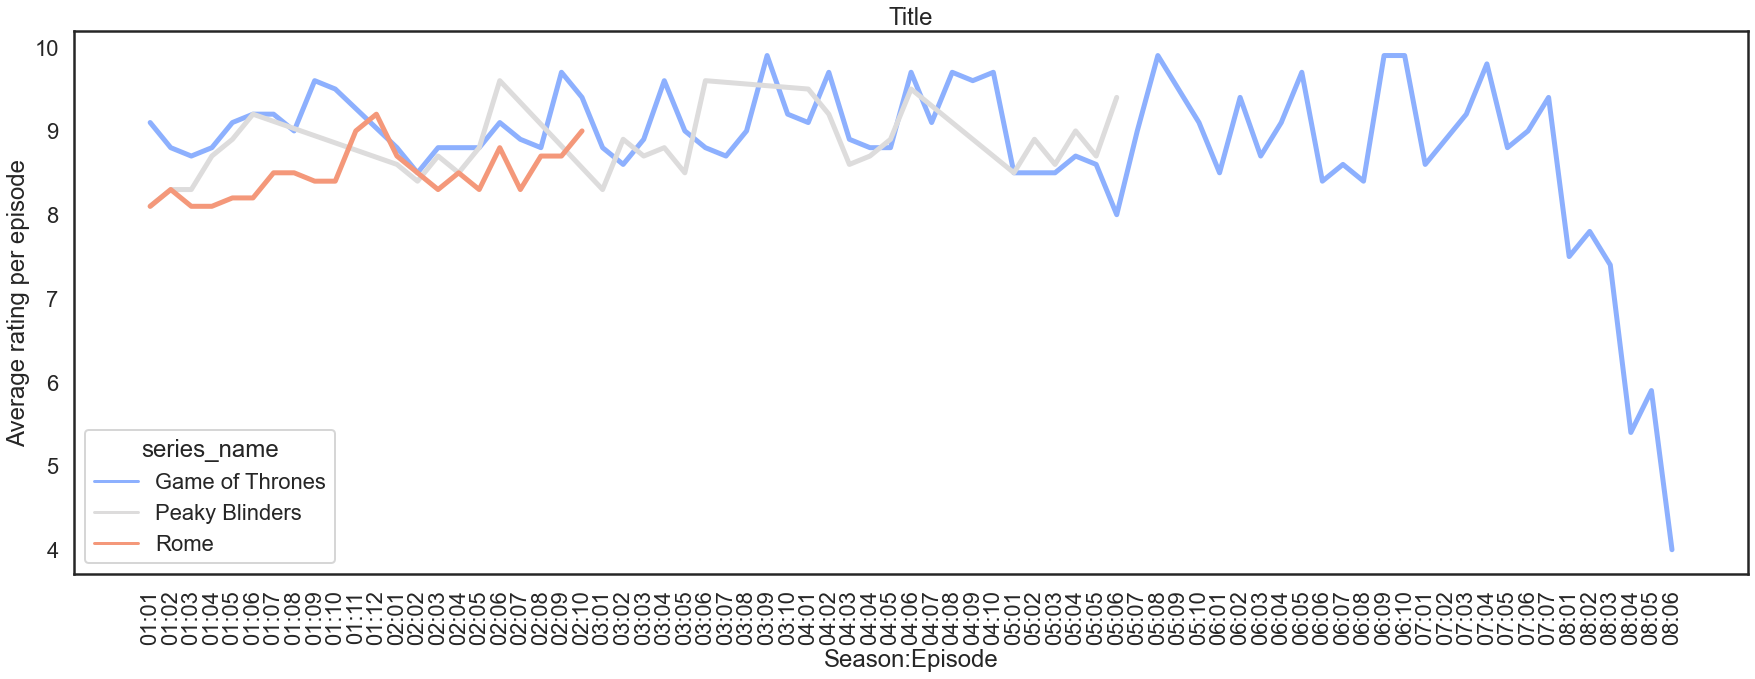

In [199]:
sns.set(rc={'figure.figsize':(30,10)})
sns.set_style('white')
sns.set_context("poster")

#sns.lineplot(data=temp_data, x="season_episode", y="episode_rating");

plt.title("Title", size=24)

g = sns.lineplot(data=temp_data.sort_values('season_episode'), 
                 x='season_episode', 
                 y="episode_rating", 
                 markers=True,
                 dashes=False,
                 hue="series_name",
                 #style="series_name",
                 lw=5, 
                 alpha=1, 
                 palette="coolwarm");

plt.xlabel("Season:Episode")
plt.ylabel("Average rating per episode")
plt.xticks(rotation=90);
